In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Ce code définit une classe appelée **Generator** qui représente un générateur dans le contexte des réseaux adverses génératifs (GANs)

1. **Structure de la classe**  
   La classe **Generator** hérite de `nn.Module`, ce qui en fait une composante d'un modèle PyTorch. Elle est conçue pour prendre un vecteur de bruit en entrée (de dimension `noise_dim`) et générer une image en sortie.

2. **Paramètres principaux**  
   - `noise_dim` : la taille du vecteur de bruit aléatoire utilisé comme entrée
   pour le générateur. Par défaut, il est fixé à 100.
   •	Le vecteur de bruit est l'entrée du générateur dans un GAN. Il fournit une base aléatoire à partir de laquelle le générateur produit des données synthétiques. (Le générateur apprend à transformer ce bruit en données réalistes (par exemple, des images de chiffres)  
   - `image_channels` : le nombre de canaux de l'image générée. Ici, il est fixé à 1, ce qui correspond à des images en niveaux de gris.  



In [2]:
# Définition du générateur (Generator)
class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_channels=1):
        super(Generator, self).__init__()

        # Le modèle est une séquence de couches fully connected
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),          # Première couche fully connected
            nn.LeakyReLU(0.2),                  # Activation avec fuite pour éviter le "dying ReLU"
            nn.Linear(256, 512),                # Deuxième couche fully connected
            nn.BatchNorm1d(512),                # Normalisation des sorties pour stabiliser l'entraînement
            nn.LeakyReLU(0.2),                  # Activation non-linéaire
            nn.Linear(512, image_channels * 28 * 28),  # Sortie: taille de l'image (1 canal, 28x28 pixels)
            nn.Tanh()                           # Activation Tanh pour ramener les valeurs entre -1 et 1
        )

    def forward(self, noise):
        # Passe avant : génération de l'image à partir du bruit
        img = self.model(noise)
        # Reshape en taille d'image 1x28x28
        img = img.view(img.size(0), 1, 28, 28)
        return img

Ce code définit un discriminateur, une partie d'un réseau qui sert à reconnaître si une image est réelle ou générée par un ordinateur. Il prend une image, la transforme en un vecteur, puis passe ce vecteur à travers plusieurs étapes pour décider si l'image est authentique. À la fin, il donne une probabilité : un chiffre proche de 1 signifie que l'image est réelle, et proche de 0 qu'elle est fausse.

In [3]:
# Définition du discriminateur (Discriminator)
class Discriminator(nn.Module):
    def __init__(self, image_channels=1):
        super(Discriminator, self).__init__()

        # Le modèle est une séquence de couches fully connected
        self.model = nn.Sequential(
            nn.Flatten(),                        # Aplatissement de l'image en vecteur
            nn.Linear(image_channels * 28 * 28, 512),  # Couche fully connected
            nn.LeakyReLU(0.2),                   # Activation avec fuite
            nn.Linear(512, 256),                 # Deuxième couche fully connected
            nn.LeakyReLU(0.2),                   # Activation avec fuite
            nn.Linear(256, 1),                   # Sortie : probabilité que l'image soit réelle
            nn.Sigmoid()                         # Activation sigmoïde pour une probabilité entre 0 et 1
        )

    def forward(self, img):
        # Passe avant : validation de l'image
        validity = self.model(img)
        return validity

Ce code définit une classe GAN qui combine deux modèles : un générateur qui crée des images à partir de bruit aléatoire et un discriminateur qui apprend à distinguer les images réelles des fausses. Pendant l’entraînement, le discriminateur s’améliore à reconnaître les images réelles, tandis que le générateur s’efforce de produire des images qui peuvent le tromper. Ce processus les améliore tous les deux, et à la fin, le GAN peut générer des images qui ressemblent à de vraies données.

In [4]:
# Classe GAN qui englobe le générateur et le discriminateur
class GAN:
    def __init__(self, noise_dim=100):
        # Détection de l'appareil (GPU si disponible)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialisation des sous-modèles
        self.generator = Generator(noise_dim).to(self.device)
        self.discriminator = Discriminator().to(self.device)

        # Fonction de perte : Binary Cross-Entropy Loss
        self.criterion = nn.BCELoss()

        # Optimiseurs pour le générateur et le discriminateur
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train(self, dataloader, num_epochs):
        for epoch in range(num_epochs):
            for real_images, _ in dataloader:
                batch_size = real_images.size(0)
                real_images = real_images.to(self.device)

                # Labels pour les images réelles et générées
                real_labels = torch.ones(batch_size, 1).to(self.device)
                fake_labels = torch.zeros(batch_size, 1).to(self.device)

                # Entraînement du discriminateur
                self.d_optimizer.zero_grad()
                real_outputs = self.discriminator(real_images)    # Sortie pour les images réelles
                d_real_loss = self.criterion(real_outputs, real_labels)

                noise = torch.randn(batch_size, 100).to(self.device)  # Bruit aléatoire
                fake_images = self.generator(noise)                  # Génération d'images
                fake_outputs = self.discriminator(fake_images.detach())  # Sortie pour les images générées
                d_fake_loss = self.criterion(fake_outputs, fake_labels)

                d_loss = d_real_loss + d_fake_loss  # Perte totale du discriminateur
                d_loss.backward()
                self.d_optimizer.step()

                # Entraînement du générateur
                self.g_optimizer.zero_grad()
                fake_outputs = self.discriminator(fake_images)  # Valider les images générées
                g_loss = self.criterion(fake_outputs, real_labels)  # Encourager le générateur à "tromper" le discriminateur
                g_loss.backward()
                self.g_optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    def generate_images(self, num_images):
        # Génération d'images
        self.generator.eval()
        with torch.no_grad():
            noise = torch.randn(num_images, 100).to(self.device)
            generated_images = self.generator(noise)
        return generated_images

Cette fonction permet de comparer visuellement des images réelles avec des images générées par un GAN. Elle affiche côte à côte deux ensembles d'images : celles provenant des données d'entraînement (réelles) et celles créées par le générateur. Chaque ensemble contient un certain nombre d'images (par défaut, 16) organisées en grille. Cela aide à évaluer la qualité des images produites par le GAN.

In [5]:
# Fonction pour visualiser les images réelles et générées
def visualize_data_comparison(real_images, generated_images, num_images=16):
    plt.figure(figsize=(15, 7))
    plt.suptitle('Comparaison Images Réelles vs Générées', fontsize=16)

    # Images réelles
    plt.subplot(1, 2, 1)
    real_grid = torchvision.utils.make_grid(real_images[:num_images], normalize=True)
    plt.title('Images Réelles MNIST')
    plt.imshow(real_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')

    # Images générées
    plt.subplot(1, 2, 2)
    generated_grid = torchvision.utils.make_grid(generated_images[:num_images], normalize=True)
    plt.title('Images Générées par le GAN')
    plt.imshow(generated_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('mnist_comparison.png')
    plt.show()

Cette fonction principale réalise toutes les étapes nécessaires pour entraîner et évaluer un GAN :  

1. **Préparation des données** : Elle applique des transformations aux images du dataset MNIST, comme la conversion en tenseurs et la normalisation des pixels pour les adapter au GAN.  

2. **Chargement des données** : Elle télécharge le dataset MNIST, l’organise en lots (batchs) et le rend prêt pour l'entraînement.  

3. **Entraînement du GAN** : Elle initialise un modèle GAN, l'entraîne pendant un certain nombre d'époques (ici, 50) avec les données chargées.  

4. **Génération et visualisation** : Après l'entraînement, elle génère des images à partir du bruit et les compare visuellement avec des images réelles du dataset MNIST pour évaluer la qualité des résultats.  

En résumé, cette fonction automatise le processus complet de création, d'entraînement et d'évaluation d'un GAN sur les données MNIST.

In [6]:

# Fonction principale
def main():
    # Transformations pour le dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalisation des pixels entre -1 et 1
    ])

    # Chargement du dataset MNIST
    dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    dataloader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=True
    )

    # Initialisation du GAN et entraînement
    gan = GAN()
    gan.train(dataloader, num_epochs=50)

    # Génération d'images
    generated_images = gan.generate_images(100)

    # Récupération d'un batch d'images réelles
    real_images, _ = next(iter(dataloader))

    # Visualisation comparative
    visualize_data_comparison(real_images, generated_images)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.55MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/50], D Loss: 0.9327, G Loss: 1.2588
Epoch [2/50], D Loss: 0.9486, G Loss: 0.8748
Epoch [3/50], D Loss: 0.9119, G Loss: 1.2542
Epoch [4/50], D Loss: 0.7428, G Loss: 1.4732
Epoch [5/50], D Loss: 0.9979, G Loss: 1.1065
Epoch [6/50], D Loss: 0.9863, G Loss: 1.4731
Epoch [7/50], D Loss: 0.9127, G Loss: 1.1136
Epoch [8/50], D Loss: 1.1277, G Loss: 0.6702
Epoch [9/50], D Loss: 0.9905, G Loss: 1.4150
Epoch [10/50], D Loss: 0.9217, G Loss: 1.0573
Epoch [11/50], D Loss: 1.2015, G Loss: 0.6649
Epoch [12/50], D Loss: 1.1130, G Loss: 0.7984
Epoch [13/50], D Loss: 1.0678, G Loss: 1.6135
Epoch [14/50], D Loss: 0.9805, G Loss: 1.2255
Epoch [15/50], D Loss: 1.1644, G Loss: 0.6664
Epoch [16/50], D Loss: 0.9425, G Loss: 1.0991
Epoch [17/50], D Loss: 1.0844, G Loss: 1.4134
Epoch [18/50], D Loss: 0.9818, G Loss: 1.4852
Epoch [19/50], D Loss: 1.1201, G Loss: 1.0115
Epoch [20/50], D Loss: 1.1732, G Loss: 0.7849
Epoch [21/50],

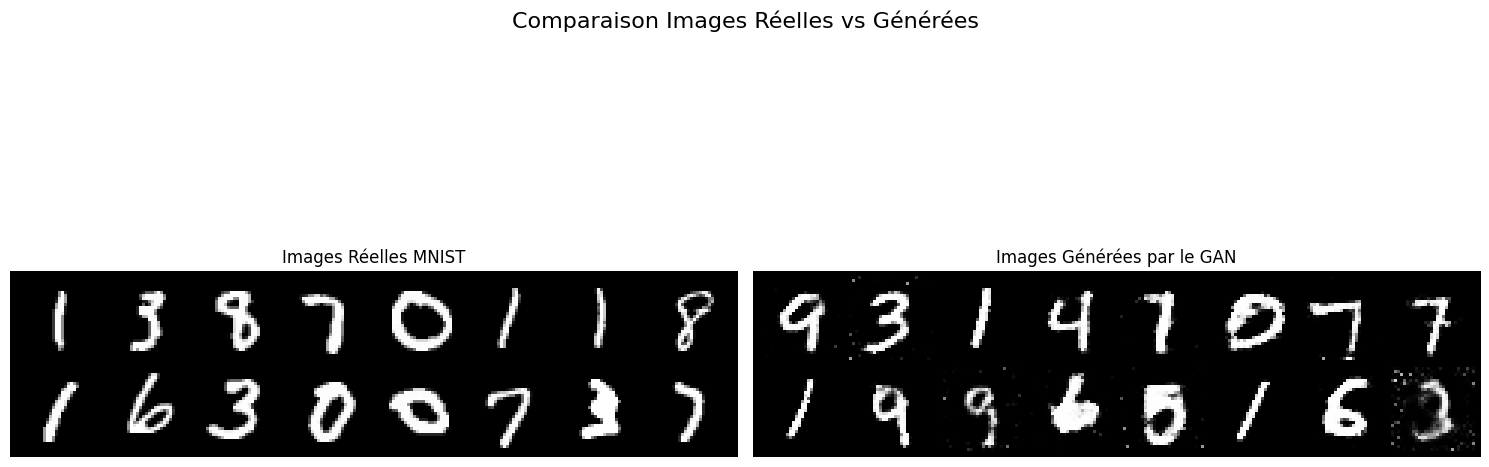

In [ ]:
# Lancement du programme
if __name__ == '__main__':
    main()